# Assignment 1 Group 6




#### Imports and inits

In [2]:
!pip install h2o
!pip install interpret
!pip install xgboost

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 265.8/265.8 MB 5.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for h2o: filename=h2o-3.46.0.6-py2.py3-none-any.whl size=265859786 sha256=307ee51583f60922be7ffbebd6548a6f466ac47b1c934b4395f7c547b7a862e4
  Stored in directory: /root/.cache/pip/wheels/62/f9/aa/687bd54342d2981bc78e22ee9b9bc39f92006e344e7aa1e0ac
Successfully built h2o
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.0/4.0 MB 34.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.4/44.4 kB 3.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 15.0/15.0 MB 92.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.7/6.7 MB 81.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.0/8.0 MB 96.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 119.4/119.4 kB 10.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.8/6.8 MB 103.5 MB/s eta 0:00:00


In [3]:
import datetime                                               # for timestamp
import h2o                                                    # base h2o package for python
from h2o.estimators.glm import H2OGeneralizedLinearEstimator  # h2o elastic net models class
from h2o.grid.grid_search import H2OGridSearch                # grid search class and syntax for h2o models
from interpret import show                                    # basic visualizations from interpret package
from interpret.glassbox import ExplainableBoostingClassifier  # interpret ebm class
from interpret.perf import ROC                                # ROC measure for ebm
import itertools                                              # for cartesian product of parameters
import matplotlib.pyplot as plt                               # basic plotting
import numpy as np                                            # for basic array manipulation
import pandas as pd                                           # for dataframe manipulation
import seaborn as sns                                         # slightly better plotting
import time                                                   # for timers
import xgboost as xgb                                         # base xgboost package for python

# set numpy random seed for better reproducibility
SEED = 12345

# set number of threads
NTHREAD = 4

h2o.init(max_mem_size='6G', nthreads=NTHREAD) # start h2o with plenty of memory and threads
h2o.remove_all()                              # clears h2o memory
h2o.no_progress()                             # turn off h2o progress indicators

Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
  Java Version: openjdk version "11.0.26" 2025-01-21; OpenJDK Runtime Environment (build 11.0.26+4-post-Ubuntu-1ubuntu122.04); OpenJDK 64-Bit Server VM (build 11.0.26+4-post-Ubuntu-1ubuntu122.04, mixed mode, sharing)
  Starting server from /usr/local/lib/python3.11/dist-packages/h2o/backend/bin/h2o.jar
  Ice root: /tmp/tmpnlflao9k
  JVM stdout: /tmp/tmpnlflao9k/h2o_unknownUser_started_from_python.out
  JVM stderr: /tmp/tmpnlflao9k/h2o_unknownUser_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.
Please download and install the latest version from: https://h2o-release.s3.amazonaws.com/h2o/latest_stable.html


H2O_cluster_uptime:,06 secs
H2O_cluster_timezone:,Etc/UTC
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.46.0.6
H2O_cluster_version_age:,4 months and 24 days
H2O_cluster_name:,H2O_from_python_unknownUser_pc9zki
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,6 Gb
H2O_cluster_total_cores:,2
H2O_cluster_allowed_cores:,2
H2O_cluster_status:,"locked, healthy"


#### Start global timer

In [4]:
tic = time.time()

#### Import data

## Mount shared drive

In [7]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


#### Assign basic modeling roles

In [8]:
data = pd.read_csv('/content/drive/My Drive/DNSC_6330_Software/data/hmda_train_preprocessed.csv')
test = pd.read_csv('/content/drive/My Drive/DNSC_6330_Software/data/hmda_test_preprocessed.csv')

In [9]:
y_name = 'high_priced'
x_names = ['term_360', 'conforming', 'debt_to_income_ratio_missing', 'loan_amount_std', 'loan_to_value_ratio_std', 'no_intro_rate_period_std',
           'intro_rate_period_std', 'property_value_std', 'income_std', 'debt_to_income_ratio_std']

## Basic data exploration

#### Histograms

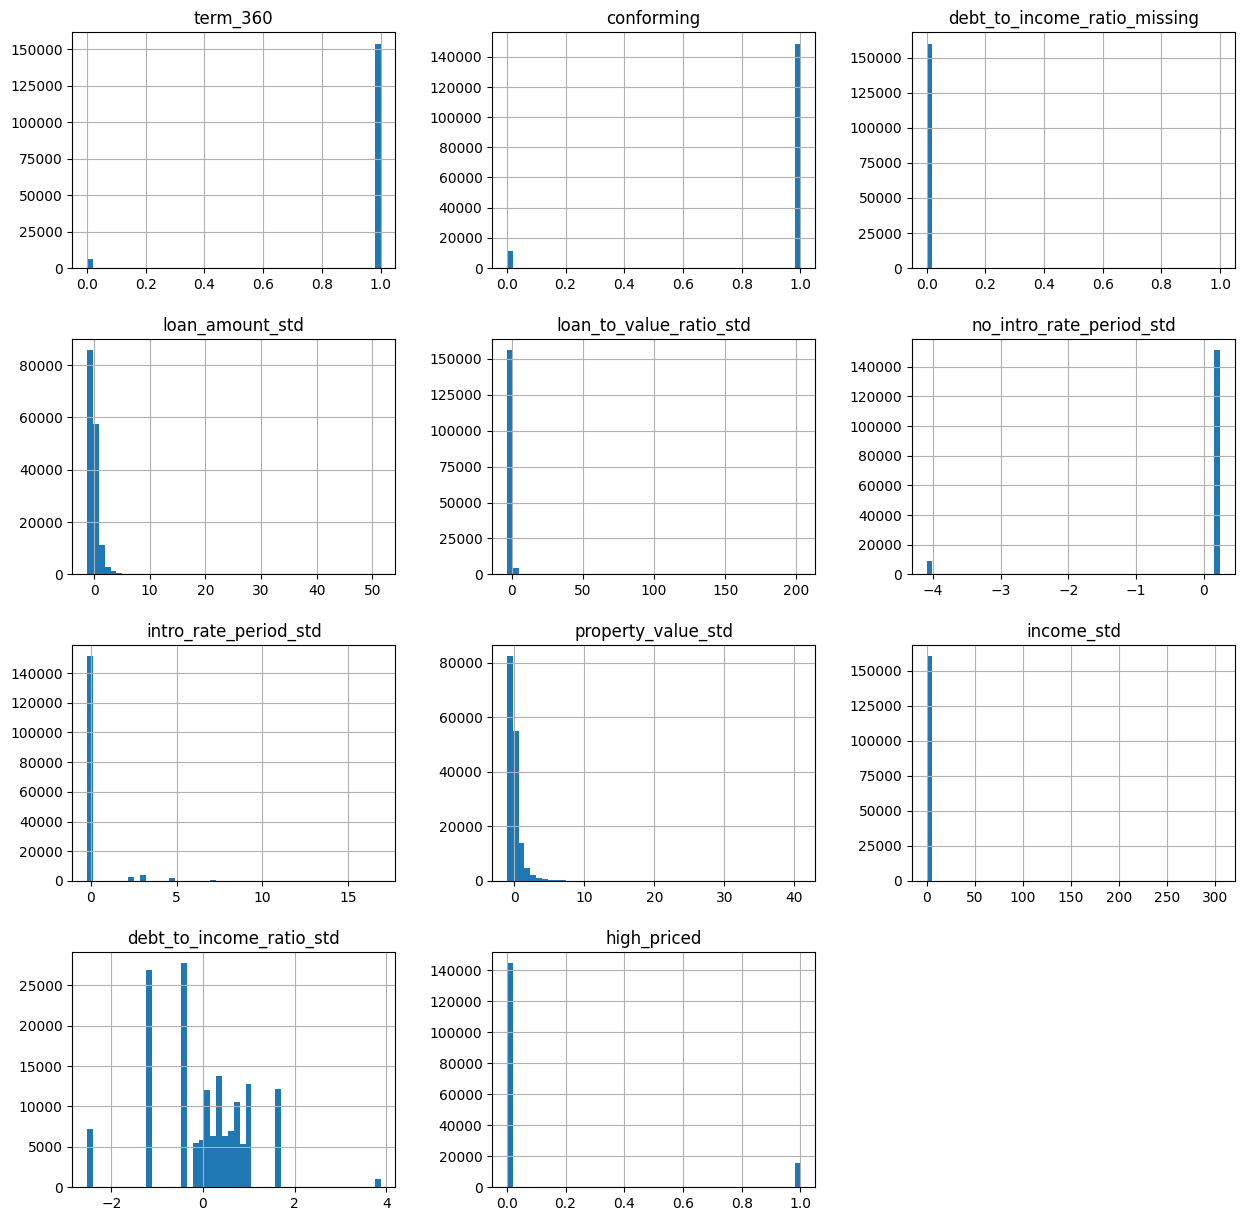

In [10]:
_ = data[x_names + [y_name]].hist(bins=50, figsize=(15, 15))

#### Correlations

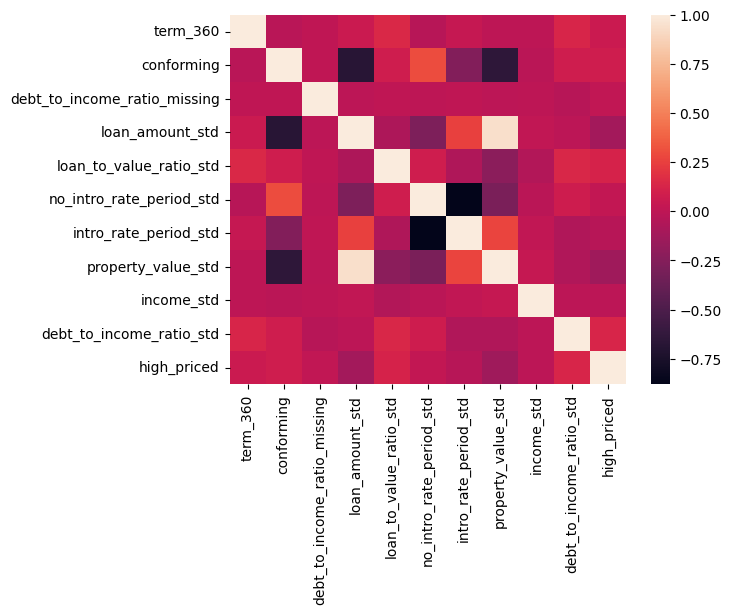

In [11]:
corr = data[x_names + [y_name]].corr()
_ = sns.heatmap(corr,
                xticklabels=corr.columns.values,
                yticklabels=corr.columns.values)

## Fit interpretable models

#### Split data into train and validation partitions

In [12]:
np.random.seed(SEED) # preserve exact reproducibility for this cell

split_ratio = 0.7 # 70%/30% train/test split

# execute split
split = np.random.rand(len(data)) < split_ratio
train = data[split]
valid = data[~split]

# summarize split
print('Train data rows = %d, columns = %d' % (train.shape[0], train.shape[1]))
print('Validation data rows = %d, columns = %d' % (valid.shape[0], valid.shape[1]))

# benchmark - Train data rows = 112253, columns = 23
# benchmark - Validation data rows = 48085, columns = 23

Train data rows = 112253, columns = 23
Validation data rows = 48085, columns = 23


### Elastic net

#### Define wrapper function for grid search

In [13]:
def glm_grid(x_names, y_name, htrain, hvalid, seed):

    """ Wrapper function for penalized GLM with alpha and lambda search.

    :param x_names: Names of input features.
    :param y_name: Name of target feature.
    :param htrain: Training H2OFrame.
    :param hvalid: Validation H2OFrame.
    :param seed: Random seed for better reproducibility.
    :return: Best H2OGeneralizedLinearEstimator.
    """

    alpha_opts = [0.01, 0.25, 0.5, 0.99]  # always keep some L2

    # define search criteria
    # i.e., over alpha
    # lamda search handled by lambda_search param below
    hyper_parameters = {'alpha': alpha_opts}

    # initialize grid search
    grid = H2OGridSearch(
        H2OGeneralizedLinearEstimator(family='binomial',
                                      lambda_search=True,
                                      seed=seed), # seed for grid search
        hyper_params=hyper_parameters)

    # execute training w/ grid search
    grid.train(y=y_name,
               x=x_names,
               training_frame=htrain,
               validation_frame=hvalid,
               seed=seed) # seed for training

    # select best model from grid search
    best_model = grid.get_grid()[0]
    del grid

    return best_model

#### Fit elastic net with grid search

In [14]:
# start local timer
glm_tic = time.time()

# convert data to h2o frames
htrain = h2o.H2OFrame(train)
hvalid = h2o.H2OFrame(valid)

# train with grid search
best_glm = glm_grid(x_names, y_name, htrain, hvalid, SEED)

# end local timer
glm_toc = time.time() - glm_tic
print('Elastic net GLM training completed in %.2f s.' % (glm_toc))

/usr/local/lib/python3.11/dist-packages/h2o/grid/grid_search.py:434: UserWarning: Adding alpha array to hyperparameter runs slower with gridsearch. This is due to the fact that the algo has to run initialization for every alpha value. Setting the alpha array as a model parameter will skip the initialization and run faster overall.
  warnings.warn(w_message)


Elastic net GLM training completed in 40.15 s.


#### Basic AUC assessment

In [15]:
print('Validation AUC: %.4f.' % best_glm.auc(valid=True))

Validation AUC: 0.7538.


#### Write submission file

In [16]:
best_glm_submit = best_glm.predict(h2o.H2OFrame(test)).as_data_frame()
best_glm_submit.drop(['predict', 'p0'], axis=1, inplace=True)
best_glm_submit.columns = ['phat']
best_glm_submit.to_csv('ph_best_glm_' + str(datetime.datetime.now().strftime("%Y_%m_%d_%H_%M_%S") + '.csv'),
                       index=False)

/usr/local/lib/python3.11/dist-packages/h2o/frame.py:1983: H2ODependencyWarning: Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using multi-thread, install polars and pyarrow and use it as pandas_df = h2o_df.as_data_frame(use_multi_thread=True)

  warnings.warn("Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using"


### Monotonic XGBoost

#### Define utility function for random grid search

In [17]:
def xgb_grid(dtrain, dvalid, mono_constraints=None, gs_params=None, n_models=None,
             ntree=None, early_stopping_rounds=None, verbose=False, seed=None):

    """ Performs a random grid search over n_models and gs_params.

    :param dtrain: Training data in LightSVM format.
    :param dvalid: Validation data in LightSVM format.
    :param mono_constraints: User-supplied monotonicity constraints.
    :param gs_params: Dictionary of lists of potential XGBoost parameters over which to search.
    :param n_models: Number of random models to evaluate.
    :param ntree: Number of trees in XGBoost model.
    :param early_stopping_rounds: XGBoost early stopping rounds.
    :param verbose: Whether to display training iterations, default False.
    :param seed: Random seed for better interpretability.
    :return: Best candidate model from random grid search.

    """

    # cartesian product of gs_params
    keys, values = zip(*gs_params.items())
    experiments = [dict(zip(keys, v)) for v in itertools.product(*values)]

    # preserve exact reproducibility for this function
    np.random.seed(SEED)

    # select randomly from cartesian product space
    selected_experiments = np.random.choice(len(experiments), n_models)

    # set global params for objective,  etc.
    params = {'booster': 'gbtree',
              'eval_metric': 'auc',
              'nthread': NTHREAD,
              'objective': 'binary:logistic',
              'seed': SEED}

    # init grid search loop
    best_candidate = None
    best_score = 0

    # grid search loop
    for i, exp in enumerate(selected_experiments):

        params.update(experiments[exp])  # override global params with current grid run params

        print('Grid search run %d/%d:' % (int(i + 1), int(n_models)))
        print('Training with parameters:', params)

        # train on current params
        watchlist = [(dtrain, 'train'), (dvalid, 'eval')]

        if mono_constraints is not None:
            params['monotone_constraints'] = mono_constraints

        candidate = xgb.train(params,
                              dtrain,
                              ntree,
                              early_stopping_rounds=early_stopping_rounds,
                              evals=watchlist,
                              verbose_eval=verbose)

        # determine if current model is better than previous best
        if candidate.best_score > best_score:
            best_candidate = candidate
            best_score = candidate.best_score
            print('Grid search new best score discovered at iteration %d/%d: %.4f.' %
                             (int(i + 1), int(n_models), candidate.best_score))

        print('---------- ----------')

    return best_candidate

#### Fit monotonic XGBoost with random grid search

In [18]:
# dictionary of hyperparameter value lists for grid search
gs_params = {'colsample_bytree': [0.3, 0.5, 0.7, 0.9],
             'colsample_bylevel': [0.3, 0.5, 0.7, 0.9],
             'eta': [0.005, 0.05, 0.5],
             'max_depth': [3, 5, 7],
             'reg_alpha': [0.0005, 0.005, 0.05],
             'reg_lambda': [0.0005, 0.005, 0.05],
             'subsample': [0.3, 0.5, 0.7, 0.9],
             'min_child_weight': [1, 5, 10],
             'gamma': [0.0, 0.1, 0.2 , 0.3, 0.4]}

# define monotonicity constraints
mono_constraints = tuple([int(i) for i in np.sign(train[x_names + [y_name]].corr()[y_name].values[:-1])])

# start local timer
mxgb_tic = time.time()

# Convert data to SVMLight format
dtrain = xgb.DMatrix(train[x_names], train[y_name])
dvalid = xgb.DMatrix(valid[x_names], valid[y_name])

# Monotonic XGBoost grid search
best_mxgb = xgb_grid(dtrain, dvalid, gs_params=gs_params, n_models=50, ntree=1000, early_stopping_rounds=100,
                     mono_constraints=mono_constraints, seed=SEED)

# end local timer
mxgb_toc = time.time() - mxgb_tic
print('Monotonic GBM training completed in %.2f s.' % (mxgb_toc))

Grid search run 1/50:
Training with parameters: {'booster': 'gbtree', 'eval_metric': 'auc', 'nthread': 4, 'objective': 'binary:logistic', 'seed': 12345, 'colsample_bytree': 0.9, 'colsample_bylevel': 0.9, 'eta': 0.5, 'max_depth': 7, 'reg_alpha': 0.0005, 'reg_lambda': 0.005, 'subsample': 0.3, 'min_child_weight': 5, 'gamma': 0.0}
Grid search new best score discovered at iteration 1/50: 0.7906.
---------- ----------
Grid search run 2/50:
Training with parameters: {'booster': 'gbtree', 'eval_metric': 'auc', 'nthread': 4, 'objective': 'binary:logistic', 'seed': 12345, 'colsample_bytree': 0.3, 'colsample_bylevel': 0.3, 'eta': 0.05, 'max_depth': 5, 'reg_alpha': 0.0005, 'reg_lambda': 0.0005, 'subsample': 0.5, 'min_child_weight': 1, 'gamma': 0.2, 'monotone_constraints': (1, 1, 1, -1, 1, 1, -1, -1, -1, 1)}
---------- ----------
Grid search run 3/50:
Training with parameters: {'booster': 'gbtree', 'eval_metric': 'auc', 'nthread': 4, 'objective': 'binary:logistic', 'seed': 12345, 'colsample_bytree'

#### Basic AUC assessment

In [19]:
print('Validation AUC: %.4f.' % best_mxgb.best_score)

Validation AUC: 0.7916.


#### Write submission file

In [20]:
dtest = xgb.DMatrix(test[x_names])
best_mxgb_submit = pd.DataFrame(best_mxgb.predict(dtest, iteration_range=(0, best_mxgb.best_iteration)), columns=['phat'])
best_mxgb_submit.to_csv('ph_best_mxgb_' + str(datetime.datetime.now().strftime("%Y_%m_%d_%H_%M_%S") + '.csv'),
                        index=False)

### Updated Monotonic XGBooster: Larger grid and 100 number of models

In [22]:
# dictionary of hyperparameter value lists for grid search
gs_params = {
    'colsample_bytree': [0.3, 0.5, 0.7, 0.9],
    'colsample_bylevel': [0.3, 0.5, 0.7, 0.9],
    'eta': [0.005, 0.05, 0.5],
    'max_depth': [3, 5, 7],
    'reg_alpha': [0.0005, 0.005, 0.05],
    'reg_lambda': [0.0005, 0.005, 0.05],
    'subsample': [0.3, 0.5, 0.7, 0.9],
    'min_child_weight': [1, 5, 10],
    'gamma': [0.0, 0.1, 0.2, 0.3, 0.4],
    # Adding more values to create a larger grid
    'n_estimators': [100, 500, 1000],
    'learning_rate': [0.01, 0.1, 0.2]
}

# define monotonicity constraints
mono_constraints = tuple([int(i) for i in np.sign(train[x_names + [y_name]].corr()[y_name].values[:-1])])

# start local timer
mxgb_tic = time.time()

# Convert data to SVMLight format
dtrain = xgb.DMatrix(train[x_names], train[y_name])
dvalid = xgb.DMatrix(valid[x_names], valid[y_name])

# Monotonic XGBoost grid search
best_mxgb = xgb_grid(dtrain, dvalid, gs_params=gs_params, n_models=100, ntree=1000, early_stopping_rounds=100,
                     mono_constraints=mono_constraints, seed=SEED)

# end local timer
mxgb_toc = time.time() - mxgb_tic
print('Monotonic GBM training completed in %.2f s.' % (mxgb_toc))

Grid search run 1/100:
Training with parameters: {'booster': 'gbtree', 'eval_metric': 'auc', 'nthread': 4, 'objective': 'binary:logistic', 'seed': 12345, 'colsample_bytree': 0.3, 'colsample_bylevel': 0.5, 'eta': 0.5, 'max_depth': 3, 'reg_alpha': 0.05, 'reg_lambda': 0.05, 'subsample': 0.3, 'min_child_weight': 5, 'gamma': 0.2, 'n_estimators': 100, 'learning_rate': 0.2}


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [12:09:05] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)


Grid search new best score discovered at iteration 1/100: 0.7877.
---------- ----------
Grid search run 2/100:
Training with parameters: {'booster': 'gbtree', 'eval_metric': 'auc', 'nthread': 4, 'objective': 'binary:logistic', 'seed': 12345, 'colsample_bytree': 0.7, 'colsample_bylevel': 0.5, 'eta': 0.005, 'max_depth': 3, 'reg_alpha': 0.005, 'reg_lambda': 0.0005, 'subsample': 0.3, 'min_child_weight': 10, 'gamma': 0.2, 'n_estimators': 500, 'learning_rate': 0.2, 'monotone_constraints': (1, 1, 1, -1, 1, 1, -1, -1, -1, 1)}


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [12:09:26] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)


Grid search new best score discovered at iteration 2/100: 0.7881.
---------- ----------
Grid search run 3/100:
Training with parameters: {'booster': 'gbtree', 'eval_metric': 'auc', 'nthread': 4, 'objective': 'binary:logistic', 'seed': 12345, 'colsample_bytree': 0.5, 'colsample_bylevel': 0.9, 'eta': 0.5, 'max_depth': 7, 'reg_alpha': 0.005, 'reg_lambda': 0.005, 'subsample': 0.7, 'min_child_weight': 5, 'gamma': 0.2, 'n_estimators': 500, 'learning_rate': 0.01, 'monotone_constraints': (1, 1, 1, -1, 1, 1, -1, -1, -1, 1)}


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [12:09:49] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)


---------- ----------
Grid search run 4/100:
Training with parameters: {'booster': 'gbtree', 'eval_metric': 'auc', 'nthread': 4, 'objective': 'binary:logistic', 'seed': 12345, 'colsample_bytree': 0.3, 'colsample_bylevel': 0.5, 'eta': 0.5, 'max_depth': 7, 'reg_alpha': 0.05, 'reg_lambda': 0.0005, 'subsample': 0.9, 'min_child_weight': 10, 'gamma': 0.4, 'n_estimators': 1000, 'learning_rate': 0.1, 'monotone_constraints': (1, 1, 1, -1, 1, 1, -1, -1, -1, 1)}


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [12:09:54] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)


---------- ----------
Grid search run 5/100:
Training with parameters: {'booster': 'gbtree', 'eval_metric': 'auc', 'nthread': 4, 'objective': 'binary:logistic', 'seed': 12345, 'colsample_bytree': 0.7, 'colsample_bylevel': 0.5, 'eta': 0.05, 'max_depth': 7, 'reg_alpha': 0.05, 'reg_lambda': 0.0005, 'subsample': 0.3, 'min_child_weight': 1, 'gamma': 0.2, 'n_estimators': 500, 'learning_rate': 0.01, 'monotone_constraints': (1, 1, 1, -1, 1, 1, -1, -1, -1, 1)}


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [12:10:15] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)


Grid search new best score discovered at iteration 5/100: 0.7896.
---------- ----------
Grid search run 6/100:
Training with parameters: {'booster': 'gbtree', 'eval_metric': 'auc', 'nthread': 4, 'objective': 'binary:logistic', 'seed': 12345, 'colsample_bytree': 0.7, 'colsample_bylevel': 0.5, 'eta': 0.05, 'max_depth': 3, 'reg_alpha': 0.005, 'reg_lambda': 0.0005, 'subsample': 0.7, 'min_child_weight': 1, 'gamma': 0.1, 'n_estimators': 1000, 'learning_rate': 0.1, 'monotone_constraints': (1, 1, 1, -1, 1, 1, -1, -1, -1, 1)}


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [12:10:50] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)


---------- ----------
Grid search run 7/100:
Training with parameters: {'booster': 'gbtree', 'eval_metric': 'auc', 'nthread': 4, 'objective': 'binary:logistic', 'seed': 12345, 'colsample_bytree': 0.7, 'colsample_bylevel': 0.3, 'eta': 0.05, 'max_depth': 3, 'reg_alpha': 0.05, 'reg_lambda': 0.0005, 'subsample': 0.9, 'min_child_weight': 1, 'gamma': 0.1, 'n_estimators': 500, 'learning_rate': 0.01, 'monotone_constraints': (1, 1, 1, -1, 1, 1, -1, -1, -1, 1)}


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [12:11:04] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)


---------- ----------
Grid search run 8/100:
Training with parameters: {'booster': 'gbtree', 'eval_metric': 'auc', 'nthread': 4, 'objective': 'binary:logistic', 'seed': 12345, 'colsample_bytree': 0.3, 'colsample_bylevel': 0.5, 'eta': 0.005, 'max_depth': 3, 'reg_alpha': 0.05, 'reg_lambda': 0.005, 'subsample': 0.7, 'min_child_weight': 5, 'gamma': 0.4, 'n_estimators': 100, 'learning_rate': 0.2, 'monotone_constraints': (1, 1, 1, -1, 1, 1, -1, -1, -1, 1)}


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [12:11:07] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)


---------- ----------
Grid search run 9/100:
Training with parameters: {'booster': 'gbtree', 'eval_metric': 'auc', 'nthread': 4, 'objective': 'binary:logistic', 'seed': 12345, 'colsample_bytree': 0.9, 'colsample_bylevel': 0.9, 'eta': 0.05, 'max_depth': 7, 'reg_alpha': 0.005, 'reg_lambda': 0.05, 'subsample': 0.3, 'min_child_weight': 1, 'gamma': 0.2, 'n_estimators': 1000, 'learning_rate': 0.2, 'monotone_constraints': (1, 1, 1, -1, 1, 1, -1, -1, -1, 1)}


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [12:11:18] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)


Grid search new best score discovered at iteration 9/100: 0.7913.
---------- ----------
Grid search run 10/100:
Training with parameters: {'booster': 'gbtree', 'eval_metric': 'auc', 'nthread': 4, 'objective': 'binary:logistic', 'seed': 12345, 'colsample_bytree': 0.3, 'colsample_bylevel': 0.5, 'eta': 0.005, 'max_depth': 5, 'reg_alpha': 0.05, 'reg_lambda': 0.005, 'subsample': 0.5, 'min_child_weight': 5, 'gamma': 0.3, 'n_estimators': 1000, 'learning_rate': 0.01, 'monotone_constraints': (1, 1, 1, -1, 1, 1, -1, -1, -1, 1)}


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [12:11:22] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)


---------- ----------
Grid search run 11/100:
Training with parameters: {'booster': 'gbtree', 'eval_metric': 'auc', 'nthread': 4, 'objective': 'binary:logistic', 'seed': 12345, 'colsample_bytree': 0.7, 'colsample_bylevel': 0.5, 'eta': 0.5, 'max_depth': 7, 'reg_alpha': 0.0005, 'reg_lambda': 0.005, 'subsample': 0.7, 'min_child_weight': 10, 'gamma': 0.3, 'n_estimators': 100, 'learning_rate': 0.01, 'monotone_constraints': (1, 1, 1, -1, 1, 1, -1, -1, -1, 1)}


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [12:11:27] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)


---------- ----------
Grid search run 12/100:
Training with parameters: {'booster': 'gbtree', 'eval_metric': 'auc', 'nthread': 4, 'objective': 'binary:logistic', 'seed': 12345, 'colsample_bytree': 0.9, 'colsample_bylevel': 0.9, 'eta': 0.005, 'max_depth': 5, 'reg_alpha': 0.0005, 'reg_lambda': 0.05, 'subsample': 0.3, 'min_child_weight': 10, 'gamma': 0.3, 'n_estimators': 100, 'learning_rate': 0.1, 'monotone_constraints': (1, 1, 1, -1, 1, 1, -1, -1, -1, 1)}


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [12:11:59] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)


---------- ----------
Grid search run 13/100:
Training with parameters: {'booster': 'gbtree', 'eval_metric': 'auc', 'nthread': 4, 'objective': 'binary:logistic', 'seed': 12345, 'colsample_bytree': 0.9, 'colsample_bylevel': 0.3, 'eta': 0.05, 'max_depth': 5, 'reg_alpha': 0.005, 'reg_lambda': 0.005, 'subsample': 0.9, 'min_child_weight': 1, 'gamma': 0.4, 'n_estimators': 100, 'learning_rate': 0.01, 'monotone_constraints': (1, 1, 1, -1, 1, 1, -1, -1, -1, 1)}


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [12:12:06] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)


---------- ----------
Grid search run 14/100:
Training with parameters: {'booster': 'gbtree', 'eval_metric': 'auc', 'nthread': 4, 'objective': 'binary:logistic', 'seed': 12345, 'colsample_bytree': 0.9, 'colsample_bylevel': 0.5, 'eta': 0.5, 'max_depth': 7, 'reg_alpha': 0.005, 'reg_lambda': 0.0005, 'subsample': 0.5, 'min_child_weight': 10, 'gamma': 0.2, 'n_estimators': 1000, 'learning_rate': 0.2, 'monotone_constraints': (1, 1, 1, -1, 1, 1, -1, -1, -1, 1)}


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [12:12:09] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)


Grid search new best score discovered at iteration 14/100: 0.7917.
---------- ----------
Grid search run 15/100:
Training with parameters: {'booster': 'gbtree', 'eval_metric': 'auc', 'nthread': 4, 'objective': 'binary:logistic', 'seed': 12345, 'colsample_bytree': 0.3, 'colsample_bylevel': 0.3, 'eta': 0.05, 'max_depth': 5, 'reg_alpha': 0.05, 'reg_lambda': 0.005, 'subsample': 0.3, 'min_child_weight': 5, 'gamma': 0.2, 'n_estimators': 500, 'learning_rate': 0.1, 'monotone_constraints': (1, 1, 1, -1, 1, 1, -1, -1, -1, 1)}


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [12:12:15] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)


---------- ----------
Grid search run 16/100:
Training with parameters: {'booster': 'gbtree', 'eval_metric': 'auc', 'nthread': 4, 'objective': 'binary:logistic', 'seed': 12345, 'colsample_bytree': 0.9, 'colsample_bylevel': 0.9, 'eta': 0.05, 'max_depth': 3, 'reg_alpha': 0.0005, 'reg_lambda': 0.0005, 'subsample': 0.5, 'min_child_weight': 10, 'gamma': 0.2, 'n_estimators': 500, 'learning_rate': 0.2, 'monotone_constraints': (1, 1, 1, -1, 1, 1, -1, -1, -1, 1)}


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [12:12:35] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)


---------- ----------
Grid search run 17/100:
Training with parameters: {'booster': 'gbtree', 'eval_metric': 'auc', 'nthread': 4, 'objective': 'binary:logistic', 'seed': 12345, 'colsample_bytree': 0.3, 'colsample_bylevel': 0.3, 'eta': 0.5, 'max_depth': 7, 'reg_alpha': 0.005, 'reg_lambda': 0.05, 'subsample': 0.5, 'min_child_weight': 10, 'gamma': 0.4, 'n_estimators': 100, 'learning_rate': 0.1, 'monotone_constraints': (1, 1, 1, -1, 1, 1, -1, -1, -1, 1)}


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [12:12:48] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)


---------- ----------
Grid search run 18/100:
Training with parameters: {'booster': 'gbtree', 'eval_metric': 'auc', 'nthread': 4, 'objective': 'binary:logistic', 'seed': 12345, 'colsample_bytree': 0.9, 'colsample_bylevel': 0.3, 'eta': 0.005, 'max_depth': 7, 'reg_alpha': 0.005, 'reg_lambda': 0.005, 'subsample': 0.9, 'min_child_weight': 10, 'gamma': 0.3, 'n_estimators': 1000, 'learning_rate': 0.1, 'monotone_constraints': (1, 1, 1, -1, 1, 1, -1, -1, -1, 1)}


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [12:13:15] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)


---------- ----------
Grid search run 19/100:
Training with parameters: {'booster': 'gbtree', 'eval_metric': 'auc', 'nthread': 4, 'objective': 'binary:logistic', 'seed': 12345, 'colsample_bytree': 0.7, 'colsample_bylevel': 0.3, 'eta': 0.05, 'max_depth': 7, 'reg_alpha': 0.005, 'reg_lambda': 0.0005, 'subsample': 0.3, 'min_child_weight': 5, 'gamma': 0.0, 'n_estimators': 100, 'learning_rate': 0.01, 'monotone_constraints': (1, 1, 1, -1, 1, 1, -1, -1, -1, 1)}


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [12:13:32] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)


---------- ----------
Grid search run 20/100:
Training with parameters: {'booster': 'gbtree', 'eval_metric': 'auc', 'nthread': 4, 'objective': 'binary:logistic', 'seed': 12345, 'colsample_bytree': 0.5, 'colsample_bylevel': 0.7, 'eta': 0.005, 'max_depth': 5, 'reg_alpha': 0.0005, 'reg_lambda': 0.005, 'subsample': 0.5, 'min_child_weight': 1, 'gamma': 0.1, 'n_estimators': 100, 'learning_rate': 0.2, 'monotone_constraints': (1, 1, 1, -1, 1, 1, -1, -1, -1, 1)}


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [12:14:03] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)


---------- ----------
Grid search run 21/100:
Training with parameters: {'booster': 'gbtree', 'eval_metric': 'auc', 'nthread': 4, 'objective': 'binary:logistic', 'seed': 12345, 'colsample_bytree': 0.7, 'colsample_bylevel': 0.9, 'eta': 0.5, 'max_depth': 3, 'reg_alpha': 0.05, 'reg_lambda': 0.005, 'subsample': 0.3, 'min_child_weight': 10, 'gamma': 0.4, 'n_estimators': 1000, 'learning_rate': 0.2, 'monotone_constraints': (1, 1, 1, -1, 1, 1, -1, -1, -1, 1)}


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [12:14:11] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)


---------- ----------
Grid search run 22/100:
Training with parameters: {'booster': 'gbtree', 'eval_metric': 'auc', 'nthread': 4, 'objective': 'binary:logistic', 'seed': 12345, 'colsample_bytree': 0.9, 'colsample_bylevel': 0.9, 'eta': 0.5, 'max_depth': 3, 'reg_alpha': 0.0005, 'reg_lambda': 0.05, 'subsample': 0.3, 'min_child_weight': 1, 'gamma': 0.0, 'n_estimators': 500, 'learning_rate': 0.01, 'monotone_constraints': (1, 1, 1, -1, 1, 1, -1, -1, -1, 1)}


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [12:14:16] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)


---------- ----------
Grid search run 23/100:
Training with parameters: {'booster': 'gbtree', 'eval_metric': 'auc', 'nthread': 4, 'objective': 'binary:logistic', 'seed': 12345, 'colsample_bytree': 0.9, 'colsample_bylevel': 0.9, 'eta': 0.5, 'max_depth': 5, 'reg_alpha': 0.005, 'reg_lambda': 0.0005, 'subsample': 0.9, 'min_child_weight': 10, 'gamma': 0.3, 'n_estimators': 500, 'learning_rate': 0.2, 'monotone_constraints': (1, 1, 1, -1, 1, 1, -1, -1, -1, 1)}


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [12:14:48] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)


---------- ----------
Grid search run 24/100:
Training with parameters: {'booster': 'gbtree', 'eval_metric': 'auc', 'nthread': 4, 'objective': 'binary:logistic', 'seed': 12345, 'colsample_bytree': 0.9, 'colsample_bylevel': 0.5, 'eta': 0.5, 'max_depth': 5, 'reg_alpha': 0.05, 'reg_lambda': 0.005, 'subsample': 0.3, 'min_child_weight': 1, 'gamma': 0.2, 'n_estimators': 100, 'learning_rate': 0.1, 'monotone_constraints': (1, 1, 1, -1, 1, 1, -1, -1, -1, 1)}


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [12:15:04] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)


---------- ----------
Grid search run 25/100:
Training with parameters: {'booster': 'gbtree', 'eval_metric': 'auc', 'nthread': 4, 'objective': 'binary:logistic', 'seed': 12345, 'colsample_bytree': 0.7, 'colsample_bylevel': 0.7, 'eta': 0.05, 'max_depth': 3, 'reg_alpha': 0.0005, 'reg_lambda': 0.05, 'subsample': 0.9, 'min_child_weight': 10, 'gamma': 0.0, 'n_estimators': 500, 'learning_rate': 0.2, 'monotone_constraints': (1, 1, 1, -1, 1, 1, -1, -1, -1, 1)}


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [12:15:09] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)


---------- ----------
Grid search run 26/100:
Training with parameters: {'booster': 'gbtree', 'eval_metric': 'auc', 'nthread': 4, 'objective': 'binary:logistic', 'seed': 12345, 'colsample_bytree': 0.3, 'colsample_bylevel': 0.3, 'eta': 0.005, 'max_depth': 3, 'reg_alpha': 0.05, 'reg_lambda': 0.0005, 'subsample': 0.7, 'min_child_weight': 1, 'gamma': 0.0, 'n_estimators': 100, 'learning_rate': 0.1, 'monotone_constraints': (1, 1, 1, -1, 1, 1, -1, -1, -1, 1)}


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [12:15:29] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)


---------- ----------
Grid search run 27/100:
Training with parameters: {'booster': 'gbtree', 'eval_metric': 'auc', 'nthread': 4, 'objective': 'binary:logistic', 'seed': 12345, 'colsample_bytree': 0.5, 'colsample_bylevel': 0.3, 'eta': 0.5, 'max_depth': 3, 'reg_alpha': 0.005, 'reg_lambda': 0.0005, 'subsample': 0.7, 'min_child_weight': 10, 'gamma': 0.1, 'n_estimators': 100, 'learning_rate': 0.2, 'monotone_constraints': (1, 1, 1, -1, 1, 1, -1, -1, -1, 1)}


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [12:15:48] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)


---------- ----------
Grid search run 28/100:
Training with parameters: {'booster': 'gbtree', 'eval_metric': 'auc', 'nthread': 4, 'objective': 'binary:logistic', 'seed': 12345, 'colsample_bytree': 0.5, 'colsample_bylevel': 0.9, 'eta': 0.05, 'max_depth': 3, 'reg_alpha': 0.05, 'reg_lambda': 0.0005, 'subsample': 0.7, 'min_child_weight': 1, 'gamma': 0.1, 'n_estimators': 1000, 'learning_rate': 0.01, 'monotone_constraints': (1, 1, 1, -1, 1, 1, -1, -1, -1, 1)}


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [12:15:59] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)


---------- ----------
Grid search run 29/100:
Training with parameters: {'booster': 'gbtree', 'eval_metric': 'auc', 'nthread': 4, 'objective': 'binary:logistic', 'seed': 12345, 'colsample_bytree': 0.5, 'colsample_bylevel': 0.5, 'eta': 0.005, 'max_depth': 5, 'reg_alpha': 0.005, 'reg_lambda': 0.0005, 'subsample': 0.9, 'min_child_weight': 5, 'gamma': 0.0, 'n_estimators': 500, 'learning_rate': 0.01, 'monotone_constraints': (1, 1, 1, -1, 1, 1, -1, -1, -1, 1)}


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [12:16:28] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)


---------- ----------
Grid search run 30/100:
Training with parameters: {'booster': 'gbtree', 'eval_metric': 'auc', 'nthread': 4, 'objective': 'binary:logistic', 'seed': 12345, 'colsample_bytree': 0.9, 'colsample_bylevel': 0.5, 'eta': 0.5, 'max_depth': 5, 'reg_alpha': 0.05, 'reg_lambda': 0.05, 'subsample': 0.3, 'min_child_weight': 10, 'gamma': 0.1, 'n_estimators': 500, 'learning_rate': 0.1, 'monotone_constraints': (1, 1, 1, -1, 1, 1, -1, -1, -1, 1)}


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [12:16:59] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)


---------- ----------
Grid search run 31/100:
Training with parameters: {'booster': 'gbtree', 'eval_metric': 'auc', 'nthread': 4, 'objective': 'binary:logistic', 'seed': 12345, 'colsample_bytree': 0.7, 'colsample_bylevel': 0.3, 'eta': 0.005, 'max_depth': 3, 'reg_alpha': 0.05, 'reg_lambda': 0.05, 'subsample': 0.3, 'min_child_weight': 10, 'gamma': 0.1, 'n_estimators': 100, 'learning_rate': 0.1, 'monotone_constraints': (1, 1, 1, -1, 1, 1, -1, -1, -1, 1)}


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [12:17:12] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)


---------- ----------
Grid search run 32/100:
Training with parameters: {'booster': 'gbtree', 'eval_metric': 'auc', 'nthread': 4, 'objective': 'binary:logistic', 'seed': 12345, 'colsample_bytree': 0.9, 'colsample_bylevel': 0.7, 'eta': 0.5, 'max_depth': 7, 'reg_alpha': 0.0005, 'reg_lambda': 0.0005, 'subsample': 0.3, 'min_child_weight': 1, 'gamma': 0.0, 'n_estimators': 1000, 'learning_rate': 0.1, 'monotone_constraints': (1, 1, 1, -1, 1, 1, -1, -1, -1, 1)}


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [12:17:34] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)


---------- ----------
Grid search run 33/100:
Training with parameters: {'booster': 'gbtree', 'eval_metric': 'auc', 'nthread': 4, 'objective': 'binary:logistic', 'seed': 12345, 'colsample_bytree': 0.5, 'colsample_bylevel': 0.7, 'eta': 0.5, 'max_depth': 5, 'reg_alpha': 0.005, 'reg_lambda': 0.05, 'subsample': 0.5, 'min_child_weight': 10, 'gamma': 0.1, 'n_estimators': 100, 'learning_rate': 0.1, 'monotone_constraints': (1, 1, 1, -1, 1, 1, -1, -1, -1, 1)}


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [12:17:43] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)


---------- ----------
Grid search run 34/100:
Training with parameters: {'booster': 'gbtree', 'eval_metric': 'auc', 'nthread': 4, 'objective': 'binary:logistic', 'seed': 12345, 'colsample_bytree': 0.3, 'colsample_bylevel': 0.5, 'eta': 0.05, 'max_depth': 7, 'reg_alpha': 0.0005, 'reg_lambda': 0.0005, 'subsample': 0.7, 'min_child_weight': 1, 'gamma': 0.4, 'n_estimators': 100, 'learning_rate': 0.2, 'monotone_constraints': (1, 1, 1, -1, 1, 1, -1, -1, -1, 1)}


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [12:18:02] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)


---------- ----------
Grid search run 35/100:
Training with parameters: {'booster': 'gbtree', 'eval_metric': 'auc', 'nthread': 4, 'objective': 'binary:logistic', 'seed': 12345, 'colsample_bytree': 0.9, 'colsample_bylevel': 0.7, 'eta': 0.005, 'max_depth': 7, 'reg_alpha': 0.005, 'reg_lambda': 0.0005, 'subsample': 0.3, 'min_child_weight': 1, 'gamma': 0.4, 'n_estimators': 500, 'learning_rate': 0.1, 'monotone_constraints': (1, 1, 1, -1, 1, 1, -1, -1, -1, 1)}


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [12:18:17] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)


---------- ----------
Grid search run 36/100:
Training with parameters: {'booster': 'gbtree', 'eval_metric': 'auc', 'nthread': 4, 'objective': 'binary:logistic', 'seed': 12345, 'colsample_bytree': 0.3, 'colsample_bylevel': 0.7, 'eta': 0.5, 'max_depth': 7, 'reg_alpha': 0.005, 'reg_lambda': 0.005, 'subsample': 0.3, 'min_child_weight': 10, 'gamma': 0.3, 'n_estimators': 1000, 'learning_rate': 0.2, 'monotone_constraints': (1, 1, 1, -1, 1, 1, -1, -1, -1, 1)}


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [12:18:26] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)


---------- ----------
Grid search run 37/100:
Training with parameters: {'booster': 'gbtree', 'eval_metric': 'auc', 'nthread': 4, 'objective': 'binary:logistic', 'seed': 12345, 'colsample_bytree': 0.7, 'colsample_bylevel': 0.9, 'eta': 0.05, 'max_depth': 7, 'reg_alpha': 0.005, 'reg_lambda': 0.0005, 'subsample': 0.5, 'min_child_weight': 5, 'gamma': 0.1, 'n_estimators': 100, 'learning_rate': 0.2, 'monotone_constraints': (1, 1, 1, -1, 1, 1, -1, -1, -1, 1)}


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [12:18:31] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)


---------- ----------
Grid search run 38/100:
Training with parameters: {'booster': 'gbtree', 'eval_metric': 'auc', 'nthread': 4, 'objective': 'binary:logistic', 'seed': 12345, 'colsample_bytree': 0.7, 'colsample_bylevel': 0.9, 'eta': 0.05, 'max_depth': 3, 'reg_alpha': 0.005, 'reg_lambda': 0.0005, 'subsample': 0.9, 'min_child_weight': 1, 'gamma': 0.2, 'n_estimators': 1000, 'learning_rate': 0.2, 'monotone_constraints': (1, 1, 1, -1, 1, 1, -1, -1, -1, 1)}


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [12:18:53] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)


---------- ----------
Grid search run 39/100:
Training with parameters: {'booster': 'gbtree', 'eval_metric': 'auc', 'nthread': 4, 'objective': 'binary:logistic', 'seed': 12345, 'colsample_bytree': 0.9, 'colsample_bylevel': 0.5, 'eta': 0.5, 'max_depth': 7, 'reg_alpha': 0.0005, 'reg_lambda': 0.05, 'subsample': 0.3, 'min_child_weight': 5, 'gamma': 0.2, 'n_estimators': 100, 'learning_rate': 0.2, 'monotone_constraints': (1, 1, 1, -1, 1, 1, -1, -1, -1, 1)}


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [12:18:58] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)


---------- ----------
Grid search run 40/100:
Training with parameters: {'booster': 'gbtree', 'eval_metric': 'auc', 'nthread': 4, 'objective': 'binary:logistic', 'seed': 12345, 'colsample_bytree': 0.5, 'colsample_bylevel': 0.5, 'eta': 0.005, 'max_depth': 3, 'reg_alpha': 0.0005, 'reg_lambda': 0.0005, 'subsample': 0.9, 'min_child_weight': 5, 'gamma': 0.2, 'n_estimators': 100, 'learning_rate': 0.2, 'monotone_constraints': (1, 1, 1, -1, 1, 1, -1, -1, -1, 1)}


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [12:19:04] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)


---------- ----------
Grid search run 41/100:
Training with parameters: {'booster': 'gbtree', 'eval_metric': 'auc', 'nthread': 4, 'objective': 'binary:logistic', 'seed': 12345, 'colsample_bytree': 0.7, 'colsample_bylevel': 0.3, 'eta': 0.5, 'max_depth': 5, 'reg_alpha': 0.005, 'reg_lambda': 0.005, 'subsample': 0.5, 'min_child_weight': 10, 'gamma': 0.3, 'n_estimators': 500, 'learning_rate': 0.2, 'monotone_constraints': (1, 1, 1, -1, 1, 1, -1, -1, -1, 1)}


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [12:19:18] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)


---------- ----------
Grid search run 42/100:
Training with parameters: {'booster': 'gbtree', 'eval_metric': 'auc', 'nthread': 4, 'objective': 'binary:logistic', 'seed': 12345, 'colsample_bytree': 0.3, 'colsample_bylevel': 0.5, 'eta': 0.05, 'max_depth': 5, 'reg_alpha': 0.05, 'reg_lambda': 0.05, 'subsample': 0.9, 'min_child_weight': 5, 'gamma': 0.0, 'n_estimators': 500, 'learning_rate': 0.2, 'monotone_constraints': (1, 1, 1, -1, 1, 1, -1, -1, -1, 1)}


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [12:19:34] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)


---------- ----------
Grid search run 43/100:
Training with parameters: {'booster': 'gbtree', 'eval_metric': 'auc', 'nthread': 4, 'objective': 'binary:logistic', 'seed': 12345, 'colsample_bytree': 0.5, 'colsample_bylevel': 0.3, 'eta': 0.5, 'max_depth': 5, 'reg_alpha': 0.0005, 'reg_lambda': 0.0005, 'subsample': 0.5, 'min_child_weight': 1, 'gamma': 0.0, 'n_estimators': 1000, 'learning_rate': 0.1, 'monotone_constraints': (1, 1, 1, -1, 1, 1, -1, -1, -1, 1)}


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [12:19:51] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)


---------- ----------
Grid search run 44/100:
Training with parameters: {'booster': 'gbtree', 'eval_metric': 'auc', 'nthread': 4, 'objective': 'binary:logistic', 'seed': 12345, 'colsample_bytree': 0.5, 'colsample_bylevel': 0.9, 'eta': 0.05, 'max_depth': 7, 'reg_alpha': 0.0005, 'reg_lambda': 0.05, 'subsample': 0.7, 'min_child_weight': 5, 'gamma': 0.1, 'n_estimators': 100, 'learning_rate': 0.01, 'monotone_constraints': (1, 1, 1, -1, 1, 1, -1, -1, -1, 1)}


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [12:20:21] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)


---------- ----------
Grid search run 45/100:
Training with parameters: {'booster': 'gbtree', 'eval_metric': 'auc', 'nthread': 4, 'objective': 'binary:logistic', 'seed': 12345, 'colsample_bytree': 0.9, 'colsample_bylevel': 0.9, 'eta': 0.05, 'max_depth': 5, 'reg_alpha': 0.05, 'reg_lambda': 0.0005, 'subsample': 0.5, 'min_child_weight': 5, 'gamma': 0.1, 'n_estimators': 100, 'learning_rate': 0.2, 'monotone_constraints': (1, 1, 1, -1, 1, 1, -1, -1, -1, 1)}


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [12:20:24] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)


---------- ----------
Grid search run 46/100:
Training with parameters: {'booster': 'gbtree', 'eval_metric': 'auc', 'nthread': 4, 'objective': 'binary:logistic', 'seed': 12345, 'colsample_bytree': 0.7, 'colsample_bylevel': 0.5, 'eta': 0.5, 'max_depth': 7, 'reg_alpha': 0.05, 'reg_lambda': 0.0005, 'subsample': 0.9, 'min_child_weight': 10, 'gamma': 0.3, 'n_estimators': 500, 'learning_rate': 0.2, 'monotone_constraints': (1, 1, 1, -1, 1, 1, -1, -1, -1, 1)}


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [12:20:29] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)


---------- ----------
Grid search run 47/100:
Training with parameters: {'booster': 'gbtree', 'eval_metric': 'auc', 'nthread': 4, 'objective': 'binary:logistic', 'seed': 12345, 'colsample_bytree': 0.3, 'colsample_bylevel': 0.5, 'eta': 0.5, 'max_depth': 3, 'reg_alpha': 0.05, 'reg_lambda': 0.05, 'subsample': 0.3, 'min_child_weight': 10, 'gamma': 0.1, 'n_estimators': 500, 'learning_rate': 0.2, 'monotone_constraints': (1, 1, 1, -1, 1, 1, -1, -1, -1, 1)}


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [12:20:37] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)


---------- ----------
Grid search run 48/100:
Training with parameters: {'booster': 'gbtree', 'eval_metric': 'auc', 'nthread': 4, 'objective': 'binary:logistic', 'seed': 12345, 'colsample_bytree': 0.5, 'colsample_bylevel': 0.5, 'eta': 0.005, 'max_depth': 3, 'reg_alpha': 0.05, 'reg_lambda': 0.005, 'subsample': 0.3, 'min_child_weight': 10, 'gamma': 0.4, 'n_estimators': 100, 'learning_rate': 0.01, 'monotone_constraints': (1, 1, 1, -1, 1, 1, -1, -1, -1, 1)}


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [12:20:54] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)


---------- ----------
Grid search run 49/100:
Training with parameters: {'booster': 'gbtree', 'eval_metric': 'auc', 'nthread': 4, 'objective': 'binary:logistic', 'seed': 12345, 'colsample_bytree': 0.5, 'colsample_bylevel': 0.3, 'eta': 0.5, 'max_depth': 3, 'reg_alpha': 0.005, 'reg_lambda': 0.005, 'subsample': 0.7, 'min_child_weight': 1, 'gamma': 0.4, 'n_estimators': 100, 'learning_rate': 0.1, 'monotone_constraints': (1, 1, 1, -1, 1, 1, -1, -1, -1, 1)}


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [12:21:24] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)


---------- ----------
Grid search run 50/100:
Training with parameters: {'booster': 'gbtree', 'eval_metric': 'auc', 'nthread': 4, 'objective': 'binary:logistic', 'seed': 12345, 'colsample_bytree': 0.7, 'colsample_bylevel': 0.9, 'eta': 0.005, 'max_depth': 3, 'reg_alpha': 0.0005, 'reg_lambda': 0.005, 'subsample': 0.5, 'min_child_weight': 5, 'gamma': 0.1, 'n_estimators': 500, 'learning_rate': 0.01, 'monotone_constraints': (1, 1, 1, -1, 1, 1, -1, -1, -1, 1)}


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [12:21:37] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)


---------- ----------
Grid search run 51/100:
Training with parameters: {'booster': 'gbtree', 'eval_metric': 'auc', 'nthread': 4, 'objective': 'binary:logistic', 'seed': 12345, 'colsample_bytree': 0.9, 'colsample_bylevel': 0.3, 'eta': 0.5, 'max_depth': 7, 'reg_alpha': 0.05, 'reg_lambda': 0.0005, 'subsample': 0.9, 'min_child_weight': 5, 'gamma': 0.0, 'n_estimators': 100, 'learning_rate': 0.1, 'monotone_constraints': (1, 1, 1, -1, 1, 1, -1, -1, -1, 1)}


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [12:22:09] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)


---------- ----------
Grid search run 52/100:
Training with parameters: {'booster': 'gbtree', 'eval_metric': 'auc', 'nthread': 4, 'objective': 'binary:logistic', 'seed': 12345, 'colsample_bytree': 0.5, 'colsample_bylevel': 0.3, 'eta': 0.05, 'max_depth': 5, 'reg_alpha': 0.0005, 'reg_lambda': 0.05, 'subsample': 0.7, 'min_child_weight': 10, 'gamma': 0.4, 'n_estimators': 100, 'learning_rate': 0.2, 'monotone_constraints': (1, 1, 1, -1, 1, 1, -1, -1, -1, 1)}


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [12:22:27] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)


---------- ----------
Grid search run 53/100:
Training with parameters: {'booster': 'gbtree', 'eval_metric': 'auc', 'nthread': 4, 'objective': 'binary:logistic', 'seed': 12345, 'colsample_bytree': 0.5, 'colsample_bylevel': 0.5, 'eta': 0.5, 'max_depth': 7, 'reg_alpha': 0.0005, 'reg_lambda': 0.0005, 'subsample': 0.9, 'min_child_weight': 1, 'gamma': 0.3, 'n_estimators': 500, 'learning_rate': 0.1, 'monotone_constraints': (1, 1, 1, -1, 1, 1, -1, -1, -1, 1)}


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [12:22:41] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)


---------- ----------
Grid search run 54/100:
Training with parameters: {'booster': 'gbtree', 'eval_metric': 'auc', 'nthread': 4, 'objective': 'binary:logistic', 'seed': 12345, 'colsample_bytree': 0.7, 'colsample_bylevel': 0.9, 'eta': 0.005, 'max_depth': 5, 'reg_alpha': 0.005, 'reg_lambda': 0.005, 'subsample': 0.7, 'min_child_weight': 1, 'gamma': 0.2, 'n_estimators': 500, 'learning_rate': 0.2, 'monotone_constraints': (1, 1, 1, -1, 1, 1, -1, -1, -1, 1)}


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [12:22:54] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)


---------- ----------
Grid search run 55/100:
Training with parameters: {'booster': 'gbtree', 'eval_metric': 'auc', 'nthread': 4, 'objective': 'binary:logistic', 'seed': 12345, 'colsample_bytree': 0.5, 'colsample_bylevel': 0.7, 'eta': 0.5, 'max_depth': 5, 'reg_alpha': 0.05, 'reg_lambda': 0.005, 'subsample': 0.7, 'min_child_weight': 10, 'gamma': 0.2, 'n_estimators': 100, 'learning_rate': 0.01, 'monotone_constraints': (1, 1, 1, -1, 1, 1, -1, -1, -1, 1)}


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [12:22:58] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)


---------- ----------
Grid search run 56/100:
Training with parameters: {'booster': 'gbtree', 'eval_metric': 'auc', 'nthread': 4, 'objective': 'binary:logistic', 'seed': 12345, 'colsample_bytree': 0.9, 'colsample_bylevel': 0.3, 'eta': 0.5, 'max_depth': 5, 'reg_alpha': 0.005, 'reg_lambda': 0.05, 'subsample': 0.5, 'min_child_weight': 10, 'gamma': 0.1, 'n_estimators': 1000, 'learning_rate': 0.2, 'monotone_constraints': (1, 1, 1, -1, 1, 1, -1, -1, -1, 1)}


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [12:23:31] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)


---------- ----------
Grid search run 57/100:
Training with parameters: {'booster': 'gbtree', 'eval_metric': 'auc', 'nthread': 4, 'objective': 'binary:logistic', 'seed': 12345, 'colsample_bytree': 0.3, 'colsample_bylevel': 0.5, 'eta': 0.5, 'max_depth': 3, 'reg_alpha': 0.0005, 'reg_lambda': 0.05, 'subsample': 0.7, 'min_child_weight': 5, 'gamma': 0.3, 'n_estimators': 100, 'learning_rate': 0.01, 'monotone_constraints': (1, 1, 1, -1, 1, 1, -1, -1, -1, 1)}


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [12:23:42] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)


---------- ----------
Grid search run 58/100:
Training with parameters: {'booster': 'gbtree', 'eval_metric': 'auc', 'nthread': 4, 'objective': 'binary:logistic', 'seed': 12345, 'colsample_bytree': 0.3, 'colsample_bylevel': 0.7, 'eta': 0.005, 'max_depth': 3, 'reg_alpha': 0.05, 'reg_lambda': 0.005, 'subsample': 0.3, 'min_child_weight': 5, 'gamma': 0.1, 'n_estimators': 1000, 'learning_rate': 0.1, 'monotone_constraints': (1, 1, 1, -1, 1, 1, -1, -1, -1, 1)}


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [12:24:11] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)


---------- ----------
Grid search run 59/100:
Training with parameters: {'booster': 'gbtree', 'eval_metric': 'auc', 'nthread': 4, 'objective': 'binary:logistic', 'seed': 12345, 'colsample_bytree': 0.7, 'colsample_bylevel': 0.3, 'eta': 0.005, 'max_depth': 3, 'reg_alpha': 0.005, 'reg_lambda': 0.0005, 'subsample': 0.9, 'min_child_weight': 10, 'gamma': 0.1, 'n_estimators': 100, 'learning_rate': 0.2, 'monotone_constraints': (1, 1, 1, -1, 1, 1, -1, -1, -1, 1)}


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [12:24:31] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)


---------- ----------
Grid search run 60/100:
Training with parameters: {'booster': 'gbtree', 'eval_metric': 'auc', 'nthread': 4, 'objective': 'binary:logistic', 'seed': 12345, 'colsample_bytree': 0.7, 'colsample_bylevel': 0.3, 'eta': 0.05, 'max_depth': 7, 'reg_alpha': 0.05, 'reg_lambda': 0.05, 'subsample': 0.5, 'min_child_weight': 1, 'gamma': 0.3, 'n_estimators': 500, 'learning_rate': 0.01, 'monotone_constraints': (1, 1, 1, -1, 1, 1, -1, -1, -1, 1)}


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [12:24:43] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)


---------- ----------
Grid search run 61/100:
Training with parameters: {'booster': 'gbtree', 'eval_metric': 'auc', 'nthread': 4, 'objective': 'binary:logistic', 'seed': 12345, 'colsample_bytree': 0.3, 'colsample_bylevel': 0.5, 'eta': 0.005, 'max_depth': 7, 'reg_alpha': 0.0005, 'reg_lambda': 0.005, 'subsample': 0.7, 'min_child_weight': 5, 'gamma': 0.2, 'n_estimators': 100, 'learning_rate': 0.2, 'monotone_constraints': (1, 1, 1, -1, 1, 1, -1, -1, -1, 1)}


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [12:24:48] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)


---------- ----------
Grid search run 62/100:
Training with parameters: {'booster': 'gbtree', 'eval_metric': 'auc', 'nthread': 4, 'objective': 'binary:logistic', 'seed': 12345, 'colsample_bytree': 0.9, 'colsample_bylevel': 0.7, 'eta': 0.005, 'max_depth': 5, 'reg_alpha': 0.05, 'reg_lambda': 0.005, 'subsample': 0.9, 'min_child_weight': 1, 'gamma': 0.3, 'n_estimators': 500, 'learning_rate': 0.01, 'monotone_constraints': (1, 1, 1, -1, 1, 1, -1, -1, -1, 1)}


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [12:24:56] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)


---------- ----------
Grid search run 63/100:
Training with parameters: {'booster': 'gbtree', 'eval_metric': 'auc', 'nthread': 4, 'objective': 'binary:logistic', 'seed': 12345, 'colsample_bytree': 0.9, 'colsample_bylevel': 0.7, 'eta': 0.5, 'max_depth': 3, 'reg_alpha': 0.005, 'reg_lambda': 0.0005, 'subsample': 0.9, 'min_child_weight': 1, 'gamma': 0.4, 'n_estimators': 500, 'learning_rate': 0.01, 'monotone_constraints': (1, 1, 1, -1, 1, 1, -1, -1, -1, 1)}


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [12:25:29] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)


---------- ----------
Grid search run 64/100:
Training with parameters: {'booster': 'gbtree', 'eval_metric': 'auc', 'nthread': 4, 'objective': 'binary:logistic', 'seed': 12345, 'colsample_bytree': 0.3, 'colsample_bylevel': 0.9, 'eta': 0.05, 'max_depth': 7, 'reg_alpha': 0.05, 'reg_lambda': 0.005, 'subsample': 0.5, 'min_child_weight': 1, 'gamma': 0.1, 'n_estimators': 1000, 'learning_rate': 0.01, 'monotone_constraints': (1, 1, 1, -1, 1, 1, -1, -1, -1, 1)}


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [12:25:57] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)


---------- ----------
Grid search run 65/100:
Training with parameters: {'booster': 'gbtree', 'eval_metric': 'auc', 'nthread': 4, 'objective': 'binary:logistic', 'seed': 12345, 'colsample_bytree': 0.7, 'colsample_bylevel': 0.5, 'eta': 0.05, 'max_depth': 3, 'reg_alpha': 0.05, 'reg_lambda': 0.005, 'subsample': 0.7, 'min_child_weight': 1, 'gamma': 0.4, 'n_estimators': 1000, 'learning_rate': 0.01, 'monotone_constraints': (1, 1, 1, -1, 1, 1, -1, -1, -1, 1)}


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [12:26:00] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)


---------- ----------
Grid search run 66/100:
Training with parameters: {'booster': 'gbtree', 'eval_metric': 'auc', 'nthread': 4, 'objective': 'binary:logistic', 'seed': 12345, 'colsample_bytree': 0.5, 'colsample_bylevel': 0.9, 'eta': 0.005, 'max_depth': 7, 'reg_alpha': 0.05, 'reg_lambda': 0.005, 'subsample': 0.5, 'min_child_weight': 10, 'gamma': 0.2, 'n_estimators': 1000, 'learning_rate': 0.01, 'monotone_constraints': (1, 1, 1, -1, 1, 1, -1, -1, -1, 1)}


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [12:26:29] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)


---------- ----------
Grid search run 67/100:
Training with parameters: {'booster': 'gbtree', 'eval_metric': 'auc', 'nthread': 4, 'objective': 'binary:logistic', 'seed': 12345, 'colsample_bytree': 0.3, 'colsample_bylevel': 0.5, 'eta': 0.5, 'max_depth': 3, 'reg_alpha': 0.005, 'reg_lambda': 0.05, 'subsample': 0.3, 'min_child_weight': 5, 'gamma': 0.3, 'n_estimators': 1000, 'learning_rate': 0.01, 'monotone_constraints': (1, 1, 1, -1, 1, 1, -1, -1, -1, 1)}


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [12:27:04] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)


---------- ----------
Grid search run 68/100:
Training with parameters: {'booster': 'gbtree', 'eval_metric': 'auc', 'nthread': 4, 'objective': 'binary:logistic', 'seed': 12345, 'colsample_bytree': 0.3, 'colsample_bylevel': 0.5, 'eta': 0.05, 'max_depth': 5, 'reg_alpha': 0.005, 'reg_lambda': 0.0005, 'subsample': 0.3, 'min_child_weight': 1, 'gamma': 0.0, 'n_estimators': 100, 'learning_rate': 0.01, 'monotone_constraints': (1, 1, 1, -1, 1, 1, -1, -1, -1, 1)}


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [12:27:06] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)


---------- ----------
Grid search run 69/100:
Training with parameters: {'booster': 'gbtree', 'eval_metric': 'auc', 'nthread': 4, 'objective': 'binary:logistic', 'seed': 12345, 'colsample_bytree': 0.9, 'colsample_bylevel': 0.7, 'eta': 0.05, 'max_depth': 7, 'reg_alpha': 0.0005, 'reg_lambda': 0.05, 'subsample': 0.9, 'min_child_weight': 5, 'gamma': 0.2, 'n_estimators': 500, 'learning_rate': 0.01, 'monotone_constraints': (1, 1, 1, -1, 1, 1, -1, -1, -1, 1)}


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [12:27:09] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)


---------- ----------
Grid search run 70/100:
Training with parameters: {'booster': 'gbtree', 'eval_metric': 'auc', 'nthread': 4, 'objective': 'binary:logistic', 'seed': 12345, 'colsample_bytree': 0.7, 'colsample_bylevel': 0.9, 'eta': 0.05, 'max_depth': 7, 'reg_alpha': 0.05, 'reg_lambda': 0.005, 'subsample': 0.9, 'min_child_weight': 1, 'gamma': 0.1, 'n_estimators': 100, 'learning_rate': 0.01, 'monotone_constraints': (1, 1, 1, -1, 1, 1, -1, -1, -1, 1)}


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [12:27:43] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)


---------- ----------
Grid search run 71/100:
Training with parameters: {'booster': 'gbtree', 'eval_metric': 'auc', 'nthread': 4, 'objective': 'binary:logistic', 'seed': 12345, 'colsample_bytree': 0.3, 'colsample_bylevel': 0.9, 'eta': 0.05, 'max_depth': 7, 'reg_alpha': 0.05, 'reg_lambda': 0.0005, 'subsample': 0.5, 'min_child_weight': 5, 'gamma': 0.3, 'n_estimators': 500, 'learning_rate': 0.1, 'monotone_constraints': (1, 1, 1, -1, 1, 1, -1, -1, -1, 1)}


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [12:28:15] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)


---------- ----------
Grid search run 72/100:
Training with parameters: {'booster': 'gbtree', 'eval_metric': 'auc', 'nthread': 4, 'objective': 'binary:logistic', 'seed': 12345, 'colsample_bytree': 0.5, 'colsample_bylevel': 0.5, 'eta': 0.05, 'max_depth': 7, 'reg_alpha': 0.05, 'reg_lambda': 0.0005, 'subsample': 0.9, 'min_child_weight': 1, 'gamma': 0.0, 'n_estimators': 1000, 'learning_rate': 0.1, 'monotone_constraints': (1, 1, 1, -1, 1, 1, -1, -1, -1, 1)}


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [12:28:31] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)


---------- ----------
Grid search run 73/100:
Training with parameters: {'booster': 'gbtree', 'eval_metric': 'auc', 'nthread': 4, 'objective': 'binary:logistic', 'seed': 12345, 'colsample_bytree': 0.9, 'colsample_bylevel': 0.3, 'eta': 0.005, 'max_depth': 7, 'reg_alpha': 0.0005, 'reg_lambda': 0.05, 'subsample': 0.3, 'min_child_weight': 10, 'gamma': 0.2, 'n_estimators': 100, 'learning_rate': 0.01, 'monotone_constraints': (1, 1, 1, -1, 1, 1, -1, -1, -1, 1)}


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [12:28:52] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)


---------- ----------
Grid search run 74/100:
Training with parameters: {'booster': 'gbtree', 'eval_metric': 'auc', 'nthread': 4, 'objective': 'binary:logistic', 'seed': 12345, 'colsample_bytree': 0.9, 'colsample_bylevel': 0.7, 'eta': 0.005, 'max_depth': 5, 'reg_alpha': 0.005, 'reg_lambda': 0.005, 'subsample': 0.9, 'min_child_weight': 1, 'gamma': 0.3, 'n_estimators': 100, 'learning_rate': 0.1, 'monotone_constraints': (1, 1, 1, -1, 1, 1, -1, -1, -1, 1)}


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [12:29:22] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)


Grid search new best score discovered at iteration 74/100: 0.7918.
---------- ----------
Grid search run 75/100:
Training with parameters: {'booster': 'gbtree', 'eval_metric': 'auc', 'nthread': 4, 'objective': 'binary:logistic', 'seed': 12345, 'colsample_bytree': 0.9, 'colsample_bylevel': 0.7, 'eta': 0.05, 'max_depth': 5, 'reg_alpha': 0.005, 'reg_lambda': 0.005, 'subsample': 0.7, 'min_child_weight': 5, 'gamma': 0.4, 'n_estimators': 100, 'learning_rate': 0.1, 'monotone_constraints': (1, 1, 1, -1, 1, 1, -1, -1, -1, 1)}


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [12:29:44] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)


---------- ----------
Grid search run 76/100:
Training with parameters: {'booster': 'gbtree', 'eval_metric': 'auc', 'nthread': 4, 'objective': 'binary:logistic', 'seed': 12345, 'colsample_bytree': 0.3, 'colsample_bylevel': 0.7, 'eta': 0.5, 'max_depth': 3, 'reg_alpha': 0.05, 'reg_lambda': 0.0005, 'subsample': 0.9, 'min_child_weight': 5, 'gamma': 0.3, 'n_estimators': 1000, 'learning_rate': 0.01, 'monotone_constraints': (1, 1, 1, -1, 1, 1, -1, -1, -1, 1)}


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [12:29:55] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)


---------- ----------
Grid search run 77/100:
Training with parameters: {'booster': 'gbtree', 'eval_metric': 'auc', 'nthread': 4, 'objective': 'binary:logistic', 'seed': 12345, 'colsample_bytree': 0.7, 'colsample_bylevel': 0.3, 'eta': 0.05, 'max_depth': 3, 'reg_alpha': 0.005, 'reg_lambda': 0.005, 'subsample': 0.5, 'min_child_weight': 1, 'gamma': 0.1, 'n_estimators': 100, 'learning_rate': 0.2, 'monotone_constraints': (1, 1, 1, -1, 1, 1, -1, -1, -1, 1)}


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [12:29:58] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)


---------- ----------
Grid search run 78/100:
Training with parameters: {'booster': 'gbtree', 'eval_metric': 'auc', 'nthread': 4, 'objective': 'binary:logistic', 'seed': 12345, 'colsample_bytree': 0.9, 'colsample_bylevel': 0.3, 'eta': 0.005, 'max_depth': 5, 'reg_alpha': 0.0005, 'reg_lambda': 0.05, 'subsample': 0.5, 'min_child_weight': 5, 'gamma': 0.1, 'n_estimators': 100, 'learning_rate': 0.01, 'monotone_constraints': (1, 1, 1, -1, 1, 1, -1, -1, -1, 1)}


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [12:30:16] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)


---------- ----------
Grid search run 79/100:
Training with parameters: {'booster': 'gbtree', 'eval_metric': 'auc', 'nthread': 4, 'objective': 'binary:logistic', 'seed': 12345, 'colsample_bytree': 0.5, 'colsample_bylevel': 0.5, 'eta': 0.5, 'max_depth': 5, 'reg_alpha': 0.05, 'reg_lambda': 0.0005, 'subsample': 0.5, 'min_child_weight': 10, 'gamma': 0.4, 'n_estimators': 500, 'learning_rate': 0.01, 'monotone_constraints': (1, 1, 1, -1, 1, 1, -1, -1, -1, 1)}


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [12:30:49] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)


---------- ----------
Grid search run 80/100:
Training with parameters: {'booster': 'gbtree', 'eval_metric': 'auc', 'nthread': 4, 'objective': 'binary:logistic', 'seed': 12345, 'colsample_bytree': 0.5, 'colsample_bylevel': 0.7, 'eta': 0.05, 'max_depth': 5, 'reg_alpha': 0.005, 'reg_lambda': 0.005, 'subsample': 0.7, 'min_child_weight': 10, 'gamma': 0.1, 'n_estimators': 100, 'learning_rate': 0.2, 'monotone_constraints': (1, 1, 1, -1, 1, 1, -1, -1, -1, 1)}


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [12:31:20] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)


---------- ----------
Grid search run 81/100:
Training with parameters: {'booster': 'gbtree', 'eval_metric': 'auc', 'nthread': 4, 'objective': 'binary:logistic', 'seed': 12345, 'colsample_bytree': 0.3, 'colsample_bylevel': 0.9, 'eta': 0.05, 'max_depth': 3, 'reg_alpha': 0.05, 'reg_lambda': 0.0005, 'subsample': 0.7, 'min_child_weight': 5, 'gamma': 0.0, 'n_estimators': 1000, 'learning_rate': 0.1, 'monotone_constraints': (1, 1, 1, -1, 1, 1, -1, -1, -1, 1)}


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [12:31:28] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)


---------- ----------
Grid search run 82/100:
Training with parameters: {'booster': 'gbtree', 'eval_metric': 'auc', 'nthread': 4, 'objective': 'binary:logistic', 'seed': 12345, 'colsample_bytree': 0.5, 'colsample_bylevel': 0.5, 'eta': 0.05, 'max_depth': 5, 'reg_alpha': 0.0005, 'reg_lambda': 0.05, 'subsample': 0.9, 'min_child_weight': 10, 'gamma': 0.2, 'n_estimators': 500, 'learning_rate': 0.1, 'monotone_constraints': (1, 1, 1, -1, 1, 1, -1, -1, -1, 1)}


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [12:31:42] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)


---------- ----------
Grid search run 83/100:
Training with parameters: {'booster': 'gbtree', 'eval_metric': 'auc', 'nthread': 4, 'objective': 'binary:logistic', 'seed': 12345, 'colsample_bytree': 0.5, 'colsample_bylevel': 0.9, 'eta': 0.005, 'max_depth': 7, 'reg_alpha': 0.0005, 'reg_lambda': 0.05, 'subsample': 0.7, 'min_child_weight': 10, 'gamma': 0.3, 'n_estimators': 1000, 'learning_rate': 0.1, 'monotone_constraints': (1, 1, 1, -1, 1, 1, -1, -1, -1, 1)}


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [12:31:49] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)


---------- ----------
Grid search run 84/100:
Training with parameters: {'booster': 'gbtree', 'eval_metric': 'auc', 'nthread': 4, 'objective': 'binary:logistic', 'seed': 12345, 'colsample_bytree': 0.7, 'colsample_bylevel': 0.7, 'eta': 0.5, 'max_depth': 3, 'reg_alpha': 0.005, 'reg_lambda': 0.0005, 'subsample': 0.9, 'min_child_weight': 10, 'gamma': 0.0, 'n_estimators': 500, 'learning_rate': 0.1, 'monotone_constraints': (1, 1, 1, -1, 1, 1, -1, -1, -1, 1)}


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [12:32:12] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)


---------- ----------
Grid search run 85/100:
Training with parameters: {'booster': 'gbtree', 'eval_metric': 'auc', 'nthread': 4, 'objective': 'binary:logistic', 'seed': 12345, 'colsample_bytree': 0.7, 'colsample_bylevel': 0.5, 'eta': 0.05, 'max_depth': 3, 'reg_alpha': 0.005, 'reg_lambda': 0.05, 'subsample': 0.9, 'min_child_weight': 10, 'gamma': 0.2, 'n_estimators': 1000, 'learning_rate': 0.2, 'monotone_constraints': (1, 1, 1, -1, 1, 1, -1, -1, -1, 1)}


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [12:32:29] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)


---------- ----------
Grid search run 86/100:
Training with parameters: {'booster': 'gbtree', 'eval_metric': 'auc', 'nthread': 4, 'objective': 'binary:logistic', 'seed': 12345, 'colsample_bytree': 0.5, 'colsample_bylevel': 0.5, 'eta': 0.005, 'max_depth': 3, 'reg_alpha': 0.0005, 'reg_lambda': 0.005, 'subsample': 0.5, 'min_child_weight': 5, 'gamma': 0.1, 'n_estimators': 1000, 'learning_rate': 0.2, 'monotone_constraints': (1, 1, 1, -1, 1, 1, -1, -1, -1, 1)}


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [12:32:41] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)


---------- ----------
Grid search run 87/100:
Training with parameters: {'booster': 'gbtree', 'eval_metric': 'auc', 'nthread': 4, 'objective': 'binary:logistic', 'seed': 12345, 'colsample_bytree': 0.5, 'colsample_bylevel': 0.3, 'eta': 0.05, 'max_depth': 5, 'reg_alpha': 0.05, 'reg_lambda': 0.005, 'subsample': 0.3, 'min_child_weight': 10, 'gamma': 0.2, 'n_estimators': 100, 'learning_rate': 0.2, 'monotone_constraints': (1, 1, 1, -1, 1, 1, -1, -1, -1, 1)}


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [12:32:51] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)


---------- ----------
Grid search run 88/100:
Training with parameters: {'booster': 'gbtree', 'eval_metric': 'auc', 'nthread': 4, 'objective': 'binary:logistic', 'seed': 12345, 'colsample_bytree': 0.7, 'colsample_bylevel': 0.9, 'eta': 0.05, 'max_depth': 7, 'reg_alpha': 0.05, 'reg_lambda': 0.05, 'subsample': 0.7, 'min_child_weight': 1, 'gamma': 0.4, 'n_estimators': 100, 'learning_rate': 0.2, 'monotone_constraints': (1, 1, 1, -1, 1, 1, -1, -1, -1, 1)}


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [12:33:11] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)


---------- ----------
Grid search run 89/100:
Training with parameters: {'booster': 'gbtree', 'eval_metric': 'auc', 'nthread': 4, 'objective': 'binary:logistic', 'seed': 12345, 'colsample_bytree': 0.5, 'colsample_bylevel': 0.3, 'eta': 0.5, 'max_depth': 7, 'reg_alpha': 0.005, 'reg_lambda': 0.0005, 'subsample': 0.7, 'min_child_weight': 1, 'gamma': 0.2, 'n_estimators': 500, 'learning_rate': 0.1, 'monotone_constraints': (1, 1, 1, -1, 1, 1, -1, -1, -1, 1)}


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [12:33:31] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)


---------- ----------
Grid search run 90/100:
Training with parameters: {'booster': 'gbtree', 'eval_metric': 'auc', 'nthread': 4, 'objective': 'binary:logistic', 'seed': 12345, 'colsample_bytree': 0.5, 'colsample_bylevel': 0.9, 'eta': 0.05, 'max_depth': 3, 'reg_alpha': 0.005, 'reg_lambda': 0.005, 'subsample': 0.3, 'min_child_weight': 10, 'gamma': 0.1, 'n_estimators': 100, 'learning_rate': 0.01, 'monotone_constraints': (1, 1, 1, -1, 1, 1, -1, -1, -1, 1)}


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [12:33:50] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)


---------- ----------
Grid search run 91/100:
Training with parameters: {'booster': 'gbtree', 'eval_metric': 'auc', 'nthread': 4, 'objective': 'binary:logistic', 'seed': 12345, 'colsample_bytree': 0.7, 'colsample_bylevel': 0.3, 'eta': 0.05, 'max_depth': 3, 'reg_alpha': 0.005, 'reg_lambda': 0.005, 'subsample': 0.7, 'min_child_weight': 5, 'gamma': 0.2, 'n_estimators': 100, 'learning_rate': 0.1, 'monotone_constraints': (1, 1, 1, -1, 1, 1, -1, -1, -1, 1)}


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [12:34:22] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)


---------- ----------
Grid search run 92/100:
Training with parameters: {'booster': 'gbtree', 'eval_metric': 'auc', 'nthread': 4, 'objective': 'binary:logistic', 'seed': 12345, 'colsample_bytree': 0.7, 'colsample_bylevel': 0.7, 'eta': 0.005, 'max_depth': 7, 'reg_alpha': 0.005, 'reg_lambda': 0.0005, 'subsample': 0.5, 'min_child_weight': 1, 'gamma': 0.2, 'n_estimators': 1000, 'learning_rate': 0.2, 'monotone_constraints': (1, 1, 1, -1, 1, 1, -1, -1, -1, 1)}


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [12:34:42] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)


---------- ----------
Grid search run 93/100:
Training with parameters: {'booster': 'gbtree', 'eval_metric': 'auc', 'nthread': 4, 'objective': 'binary:logistic', 'seed': 12345, 'colsample_bytree': 0.3, 'colsample_bylevel': 0.7, 'eta': 0.005, 'max_depth': 3, 'reg_alpha': 0.05, 'reg_lambda': 0.0005, 'subsample': 0.5, 'min_child_weight': 5, 'gamma': 0.4, 'n_estimators': 500, 'learning_rate': 0.1, 'monotone_constraints': (1, 1, 1, -1, 1, 1, -1, -1, -1, 1)}


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [12:34:50] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)


---------- ----------
Grid search run 94/100:
Training with parameters: {'booster': 'gbtree', 'eval_metric': 'auc', 'nthread': 4, 'objective': 'binary:logistic', 'seed': 12345, 'colsample_bytree': 0.7, 'colsample_bylevel': 0.9, 'eta': 0.005, 'max_depth': 5, 'reg_alpha': 0.0005, 'reg_lambda': 0.0005, 'subsample': 0.3, 'min_child_weight': 1, 'gamma': 0.0, 'n_estimators': 1000, 'learning_rate': 0.01, 'monotone_constraints': (1, 1, 1, -1, 1, 1, -1, -1, -1, 1)}


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [12:35:09] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)


---------- ----------
Grid search run 95/100:
Training with parameters: {'booster': 'gbtree', 'eval_metric': 'auc', 'nthread': 4, 'objective': 'binary:logistic', 'seed': 12345, 'colsample_bytree': 0.7, 'colsample_bylevel': 0.9, 'eta': 0.5, 'max_depth': 3, 'reg_alpha': 0.0005, 'reg_lambda': 0.0005, 'subsample': 0.3, 'min_child_weight': 5, 'gamma': 0.0, 'n_estimators': 100, 'learning_rate': 0.01, 'monotone_constraints': (1, 1, 1, -1, 1, 1, -1, -1, -1, 1)}


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [12:35:43] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)


---------- ----------
Grid search run 96/100:
Training with parameters: {'booster': 'gbtree', 'eval_metric': 'auc', 'nthread': 4, 'objective': 'binary:logistic', 'seed': 12345, 'colsample_bytree': 0.5, 'colsample_bylevel': 0.5, 'eta': 0.005, 'max_depth': 7, 'reg_alpha': 0.0005, 'reg_lambda': 0.005, 'subsample': 0.9, 'min_child_weight': 10, 'gamma': 0.3, 'n_estimators': 100, 'learning_rate': 0.2, 'monotone_constraints': (1, 1, 1, -1, 1, 1, -1, -1, -1, 1)}


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [12:36:13] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)


---------- ----------
Grid search run 97/100:
Training with parameters: {'booster': 'gbtree', 'eval_metric': 'auc', 'nthread': 4, 'objective': 'binary:logistic', 'seed': 12345, 'colsample_bytree': 0.5, 'colsample_bylevel': 0.5, 'eta': 0.005, 'max_depth': 7, 'reg_alpha': 0.05, 'reg_lambda': 0.0005, 'subsample': 0.7, 'min_child_weight': 10, 'gamma': 0.2, 'n_estimators': 100, 'learning_rate': 0.01, 'monotone_constraints': (1, 1, 1, -1, 1, 1, -1, -1, -1, 1)}


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [12:36:25] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)


---------- ----------
Grid search run 98/100:
Training with parameters: {'booster': 'gbtree', 'eval_metric': 'auc', 'nthread': 4, 'objective': 'binary:logistic', 'seed': 12345, 'colsample_bytree': 0.5, 'colsample_bylevel': 0.7, 'eta': 0.05, 'max_depth': 3, 'reg_alpha': 0.05, 'reg_lambda': 0.005, 'subsample': 0.3, 'min_child_weight': 10, 'gamma': 0.0, 'n_estimators': 1000, 'learning_rate': 0.1, 'monotone_constraints': (1, 1, 1, -1, 1, 1, -1, -1, -1, 1)}


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [12:36:56] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)


---------- ----------
Grid search run 99/100:
Training with parameters: {'booster': 'gbtree', 'eval_metric': 'auc', 'nthread': 4, 'objective': 'binary:logistic', 'seed': 12345, 'colsample_bytree': 0.7, 'colsample_bylevel': 0.9, 'eta': 0.5, 'max_depth': 3, 'reg_alpha': 0.0005, 'reg_lambda': 0.005, 'subsample': 0.9, 'min_child_weight': 1, 'gamma': 0.3, 'n_estimators': 1000, 'learning_rate': 0.01, 'monotone_constraints': (1, 1, 1, -1, 1, 1, -1, -1, -1, 1)}


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [12:37:19] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)


---------- ----------
Grid search run 100/100:
Training with parameters: {'booster': 'gbtree', 'eval_metric': 'auc', 'nthread': 4, 'objective': 'binary:logistic', 'seed': 12345, 'colsample_bytree': 0.3, 'colsample_bylevel': 0.7, 'eta': 0.005, 'max_depth': 7, 'reg_alpha': 0.0005, 'reg_lambda': 0.005, 'subsample': 0.9, 'min_child_weight': 5, 'gamma': 0.3, 'n_estimators': 100, 'learning_rate': 0.2, 'monotone_constraints': (1, 1, 1, -1, 1, 1, -1, -1, -1, 1)}


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [12:37:47] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)


---------- ----------
Monotonic GBM training completed in 1738.74 s.


#### Basic AUC assessment

In [23]:
print('Validation AUC: %.4f.' % best_mxgb.best_score)

Validation AUC: 0.7918.


#### Write submission file

In [24]:
dtest = xgb.DMatrix(test[x_names])
best_mxgb_submit = pd.DataFrame(best_mxgb.predict(dtest, iteration_range=(0, best_mxgb.best_iteration)), columns=['phat'])
best_mxgb_submit.to_csv('ph_best_mxgb_' + str(datetime.datetime.now().strftime("%Y_%m_%d_%H_%M_%S") + '.csv'),
                        index=False)

### Explainable Boosting Machine

#### Define utility function for random grid search

In [25]:
def ebm_grid(train, valid, x_names, y_name, gs_params=None, n_models=None, early_stopping_rounds=None, seed=None):

    """ Performs a random grid search over n_models and gs_params.

    :param train: Training data as Pandas DataFrame.
    :param valid: Validation data as Pandas DataFrame.
    :param x_names: Names of input features.
    :param y_name: Name of target feature.
    :param gs_params: Dictionary of lists of potential EBM parameters over which to search.
    :param n_models: Number of random models to evaluate.
    :param early_stopping_rounds: EBM early stopping rounds.
    :param seed: Random seed for better interpretability.
    :return: Best candidate model from random grid search.

    """

    # cartesian product of gs_params
    keys, values = zip(*gs_params.items())
    experiments = [dict(zip(keys, v)) for v in itertools.product(*values)]

    # preserve exact reproducibility for this function
    np.random.seed(SEED)

    # select randomly from cartesian product space
    selected_experiments = np.random.choice(len(experiments), n_models)

    # set global params for seed, etc.
    params = {'n_jobs': NTHREAD,
              'early_stopping_rounds': early_stopping_rounds,
              'random_state': SEED}

    # init grid search loop
    best_candidate = None
    best_score = 0

    # grid search loop
    for i, exp in enumerate(selected_experiments):

        params.update(experiments[exp])  # override global params with current grid run params

        print('Grid search run %d/%d:' % (int(i + 1), int(n_models)))
        print('Training with parameters:', params)

        # train
        ebm = ExplainableBoostingClassifier(**params)
        candidate = ebm.fit(train[x_names], train[y_name])

        # calculate AUC
        ebm_perf = ROC(ebm.predict_proba).explain_perf(valid[x_names], valid[y_name])
        candidate_best_score = ebm_perf._internal_obj['overall']['auc']

        # determine if current model is better than previous best
        if candidate_best_score > best_score:
            best_candidate = candidate
            best_score = candidate_best_score
            print('Grid search new best score discovered at iteration %d/%d: %.4f.' %
                             (int(i + 1), int(n_models), candidate_best_score))

        print('---------- ----------')

        del ebm

    return best_candidate

#### Fit EBM with random grid search

In [27]:
# dictionary of hyperparameter value lists for grid search
gs_params = {'max_bins': [128, 256, 512],
             'max_interaction_bins': [16, 32, 64],
             'interactions': [5, 10, 15],
             'outer_bags': [4, 8, 12],
             'inner_bags': [0, 4],
             'learning_rate': [0.001, 0.01, 0.05],
             'validation_size': [0.1, 0.25, 0.5],
             'min_samples_leaf': [1, 2, 5, 10],
             'max_leaves': [1, 3, 5]}

# start local timer
ebm_tic = time.time()

# EBM grid search
best_ebm = ebm_grid(train, valid, x_names, y_name, gs_params=gs_params, n_models=10,
                    early_stopping_rounds=100, seed=SEED)

# end local timer
ebm_toc = time.time() - ebm_tic
print('EBM training completed in %.2f s.' % (ebm_toc))

Grid search run 1/10:
Training with parameters: {'n_jobs': 4, 'early_stopping_rounds': 100, 'random_state': 12345, 'max_bins': 512, 'max_interaction_bins': 16, 'interactions': 5, 'outer_bags': 4, 'inner_bags': 0, 'learning_rate': 0.05, 'validation_size': 0.25, 'min_samples_leaf': 1, 'max_leaves': 3}
Grid search new best score discovered at iteration 1/10: 0.8206.
---------- ----------
Grid search run 2/10:
Training with parameters: {'n_jobs': 4, 'early_stopping_rounds': 100, 'random_state': 12345, 'max_bins': 128, 'max_interaction_bins': 32, 'interactions': 5, 'outer_bags': 8, 'inner_bags': 0, 'learning_rate': 0.001, 'validation_size': 0.25, 'min_samples_leaf': 2, 'max_leaves': 5}
Grid search new best score discovered at iteration 2/10: 0.8210.
---------- ----------
Grid search run 3/10:
Training with parameters: {'n_jobs': 4, 'early_stopping_rounds': 100, 'random_state': 12345, 'max_bins': 512, 'max_interaction_bins': 16, 'interactions': 5, 'outer_bags': 4, 'inner_bags': 0, 'learning_

#### Basic AUC assessment

In [28]:
best_ebm_perf = ROC(best_ebm.predict_proba).explain_perf(valid[x_names], valid[y_name])
print('Validation AUC: %.4f.' % best_ebm_perf._internal_obj['overall']['auc'])

Validation AUC: 0.8250.


#### Write submission file

In [29]:
best_ebm_submit = pd.DataFrame(best_ebm.predict_proba(test[x_names])[:, 1], columns=['phat'])
best_ebm_submit.to_csv('ph_best_ebm_' + str(datetime.datetime.now().strftime("%Y_%m_%d_%H_%M_%S") + '.csv'),
                        index=False)

#### Fit EBM with random grid search: Increased number of model

In [30]:
# dictionary of hyperparameter value lists for grid search
gs_params = {
    'max_bins': [128, 256, 512],
    'max_interaction_bins': [16, 32, 64],
    'interactions': [5, 10, 15],
    'outer_bags': [4, 8, 12],
    'inner_bags': [0, 4],
    'learning_rate': [0.001, 0.01, 0.05],
    'validation_size': [0.1, 0.25, 0.5],
    'min_samples_leaf': [1, 2, 5, 10],
    'max_leaves': [1, 3, 5]
}

# start local timer
ebm_tic = time.time()

# EBM grid search
best_ebm = ebm_grid(train, valid, x_names, y_name, gs_params=gs_params, n_models=20,
                    early_stopping_rounds=100, seed=SEED)
# end local timer
ebm_toc = time.time() - ebm_tic
print('EBM training completed in %.2f s.' % (ebm_toc))

Grid search run 1/20:
Training with parameters: {'n_jobs': 4, 'early_stopping_rounds': 100, 'random_state': 12345, 'max_bins': 512, 'max_interaction_bins': 16, 'interactions': 5, 'outer_bags': 4, 'inner_bags': 0, 'learning_rate': 0.05, 'validation_size': 0.25, 'min_samples_leaf': 1, 'max_leaves': 3}
Grid search new best score discovered at iteration 1/20: 0.8206.
---------- ----------
Grid search run 2/20:
Training with parameters: {'n_jobs': 4, 'early_stopping_rounds': 100, 'random_state': 12345, 'max_bins': 128, 'max_interaction_bins': 32, 'interactions': 5, 'outer_bags': 8, 'inner_bags': 0, 'learning_rate': 0.001, 'validation_size': 0.25, 'min_samples_leaf': 2, 'max_leaves': 5}
Grid search new best score discovered at iteration 2/20: 0.8210.
---------- ----------
Grid search run 3/20:
Training with parameters: {'n_jobs': 4, 'early_stopping_rounds': 100, 'random_state': 12345, 'max_bins': 512, 'max_interaction_bins': 16, 'interactions': 5, 'outer_bags': 4, 'inner_bags': 0, 'learning_

#### Basic AUC assessment

In [32]:
best_ebm_perf = ROC(best_ebm.predict_proba).explain_perf(valid[x_names], valid[y_name])
print('Validation AUC: %.4f.' % best_ebm_perf._internal_obj['overall']['auc'])

Validation AUC: 0.8250.


#### Write submission file

In [33]:
best_ebm_submit = pd.DataFrame(best_ebm.predict_proba(test[x_names])[:, 1], columns=['phat'])
best_ebm_submit.to_csv('ph_best_ebm_' + str(datetime.datetime.now().strftime("%Y_%m_%d_%H_%M_%S") + '.csv'),
                        index=False)

#### End timer

In [34]:
toc = time.time() - tic
print('All tasks completed in %.2f s.' % (toc))

All tasks completed in 14226.21 s.


#### Shutdown h2o

In [35]:
h2o.cluster().shutdown(prompt=False)

H2O session _sid_b451 closed.


In [38]:
import os
print("Current working directory:", os.getcwd())

Current working directory: /content
